### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.
File 'RGBNIR_DSM_CHM_VIf_v4.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

### Instructions
- if not, create a anaconda environment, e.g. pysr
- once completed, in the terminal, 
- in the pysr environment installa modules:
- conda install pysr
- conda install matplotlib

- activate environment and pass two commands:
- conda activate pysr
- python -c "import pysr
- last commands will install julia libraries, necessary to run the notebook.

Julia and Julia dependencies are installed at first import:

In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [2]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Simple PySR example:


use Sergio's v4 dataset, predict LAI

In [3]:
df = pd.read_csv('RGBNIR_DSM_CHM_VIf_v4.csv')
# print(df.head())
X = df.iloc[:,1:-3]
y = df.LAI
print(X.head())


        Red     Green      Blue       NIR        FC       ch1        CH  \
0  0.020630  0.030237  0.003344  0.219818  0.680556  2.275999  2.451676   
1  0.020253  0.030407  0.003233  0.223823  0.652778  2.180176  2.469830   
2  0.022048  0.030032  0.003725  0.210354  0.598958  2.232824  2.363652   
3  0.022679  0.030747  0.003710  0.220522  0.500000  1.980601  2.298613   
4  0.023883  0.028469  0.003943  0.198092  0.522569  2.300652  2.226254   

         wc        WC      geom  ...     RGBVI      RGRI       RI4XS  \
0  1.076450  0.999317  5.576198  ...  0.859666  0.682277  509.138228   
1  1.077895  0.951482  5.123413  ...  0.867741  0.666062  479.839566   
2  0.965705  0.912254  4.814528  ...  0.833071  0.734158  597.604433   
3  0.908815  0.783081  3.565081  ...  0.836553  0.737611  575.514103   
4  0.817703  0.845029  4.328101  ...  0.791812  0.838918  868.336743   

         SI         SR      TDVI       TGI       TVI      TriVI      VARI  
0  0.981867  10.655179  0.396112  1.9498

By default, we will set up 50 populations of expressions (which evolve independently except for migrations),# use 8 threads, and use `"best"` for our model selection strategy:

In [4]:
default_pysr_params = dict(
    populations=8,    # ^ Assuming we have 4 cores, this means 2 populations per core, so one is always running.
    population_size=50, # ^ Number of equations per population
    model_selection="best", #"score" is also an option,
    random_state=0, # this line ensure reproducible results
    maxsize=20, # maximum complexity of the equations, increase to 200 for more complex equations
    deterministic=True, #   to ensure reproducible results
    parallelism='serial', # to avoid parallel computing issues on some systems, change to 'serial' if needed
    # select_k_features=10, # to automatically select few predictors from the entire set of predictor options, activate/deactive as you wish
    # denoise=True, # to remove scatteting on y, activate/deactivate as you wish
    verbosity =0,
    elementwise_loss= "L2DistLoss()",  #  (mean square)
    #niterations=10000000,  # Run forever
    #timeout_in_seconds=3600*2,  # but stop after 2 hours
    )

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [ ]:
# Learn equations
model = PySRRegressor(
    niterations=100, # number of optimization iterations, comment this if you use timeout_in_seconds and ninterations in the cell above
    binary_operators=["+", "*","-","/"],
    unary_operators=["sqrt", "exp", "log"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    **default_pysr_params,
)

model.fit(X, y)

c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          2.3271852   
	1         0.155020                                          exp(GEMI)   
	2         0.533292                                    3.3589349 / ch1   
	3         0.076240                                     wc * exp(TDVI)   
	4   >>>>  0.247594                             (wc + 2.6554573) - ch1   
	5         0.018729                            (wc + sqrt(GRVI)) - ch1   
	6         0.019907                    wc + ((GEMI + 1.8524318) - ch1)   
	7         0.127534         ((log(CIG) - ch1) + 1.1166455) / 0.5368515   
	8         0.052824     ((GRVI - -6.9260945) / (CH + ch1)) + -1.972763   
	9         0.016660  (NLI + ((GRVI - -6.153985) / (CH + ch1))) - 2....   
	10        0.009572  ((log(wc) + (GRVI - -4.450551)) / (CH + ch1)) ...   
	11        0.019139  (log(sqrt(wc)) + ((GRVI - -4.4504013) / (CH + ...   
	12        0.057101  (((GRVI * SAVI) - -6.6481705) / (CH + ch1)) - ...   
	13        0.000803  (log(wc) - sqrt(wc)) + (((sqrt(DVI) * GRVI) - ...   
	14        0.008017  (log(wc) + (((GRVI * SAVI) - -6.9225726) / (ch...   
	15        0.000002  ((log(wc) + (((GRVI * SAVI) - -6.9063573) / (C...   
	16        0.003201  (log(wc) + ((((SAVI * GRVI) - -6.5072136) / (c...   
	
	        loss  complexity  
	0   1.315314           1  
	1   1.126433           2  
	2   0.660845           3  
	3   0.612335           4  
	4   0.478036           5  
	5   0.469166           6  
	6   0.459919           7  
	7   0.404850           8  
	8   0.384019           9  
	9   0.371434          11  
	10  0.367896          12  
	11  0.360922          13  
	12  0.340890          14  
	13  0.340343          16  
	14  0.337626          17  
	15  0.337624          19  
	16  0.336545          20  
]

We can print the model, which will print out all the discovered expressions:

In [6]:
print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          2.3271852   
	1         0.155020                                          exp(GEMI)   
	2         0.533292                                    3.3589349 / ch1   
	3         0.076240                                     wc * exp(TDVI)   
	4   >>>>  0.247594                             (wc + 2.6554573) - ch1   
	5         0.018729                            (wc + sqrt(GRVI)) - ch1   
	6         0.019907                    wc + ((GEMI + 1.8524318) - ch1)   
	7         0.127534         ((log(CIG) - ch1) + 1.1166455) / 0.5368515   
	8         0.052824     ((GRVI - -6.9260945) / (CH + ch1)) + -1.972763   
	9         0.016660  (NLI + ((GRVI - -6.153985) / (CH + ch1))) - 2....   
	10        0.009572  ((log(wc) + (GRVI - -4.450551)) / (CH + ch1)) ...   
	11        0.019139  (log(sqrt(wc)) + ((GRVI - -4.4504013) / (CH + ...   
	12      

We can also view the SymPy format of the best expression:

In [7]:
model.sympy()

-ch1 + wc + 2.6554573

We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

In [8]:
model.sympy(8)

-1.972763 + (GRVI - 1*(-6.9260945))/(CH + ch1)

## Output

`model.equations_` is a Pandas DataFrame. We can export the results in various ways:

In [9]:
model.latex()

'- ch_{1} + wc + 2.66'

These is also `model.sympy(), model.jax(), model.pytorch()`. All of these can take an index as input, to get the result for an arbitrary equation in the list.

We can also use `model.predict` for arbitrary equations, with the default equation being the one chosen by `model_selection`:

ypredict = model.predict(X)
ypredict_simpler = model.predict(X, 2)

print("Default selection MSE:", np.power(ypredict - y, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y, 2).mean())

Plotting the first solutions

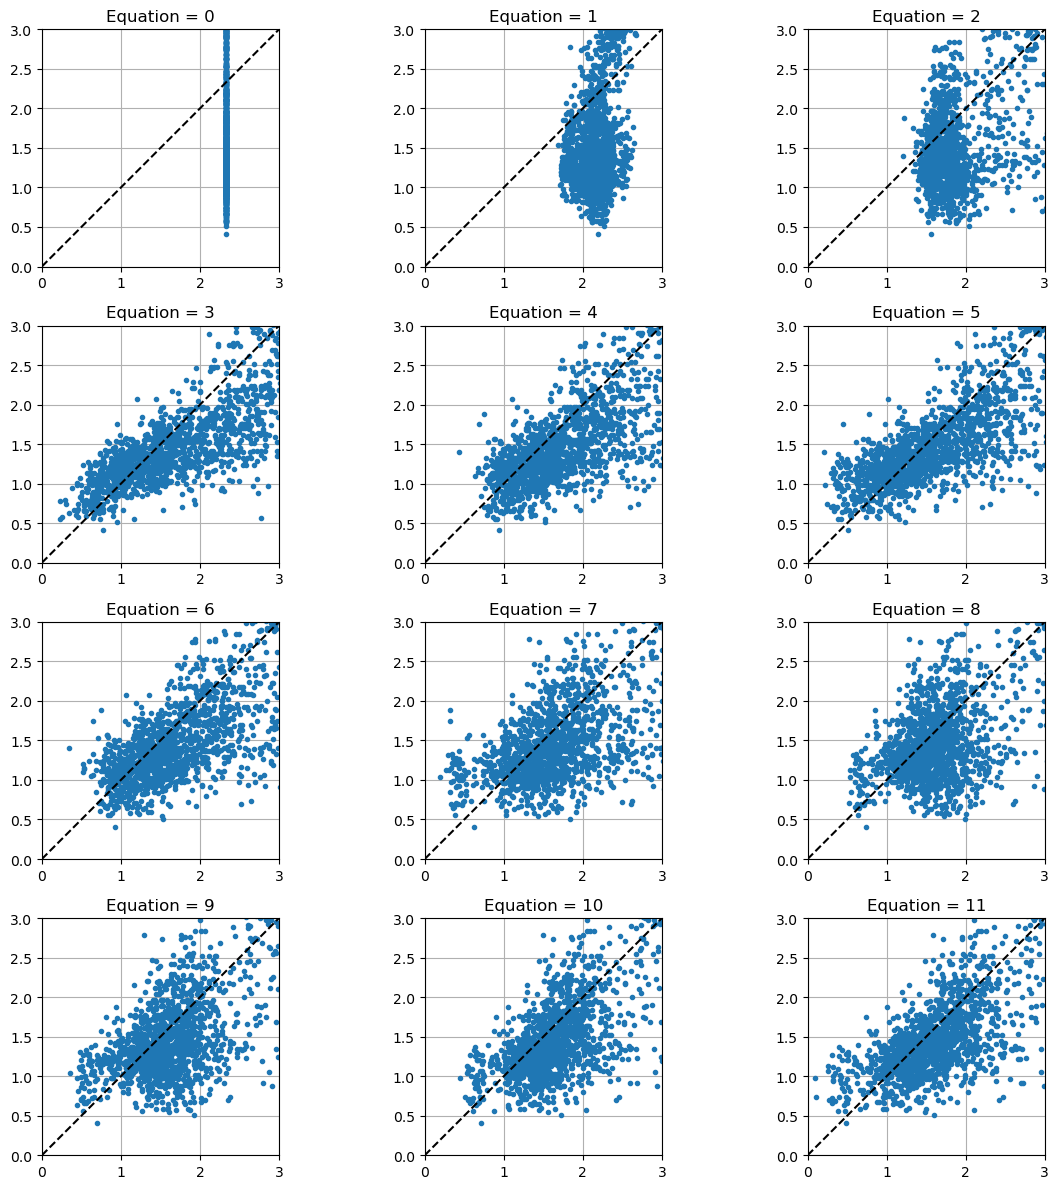

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

it = np.linspace(0,11,12, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.plot(ypredict_simpler, y,'.')
    ax.grid(True)
    # ax.set_xlabel("Modeled LAI")
    # ax.set_ylabel("Measured LAI")
    ax.plot( [0,5], [0,5], linestyle='--', color='k' )

    ax.set_aspect('equal')
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    mse =np.power(ypredict_simpler - y, 2).mean()
    ax.set_title('Equation = ' + str(i))
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Plotting the difference between the predicted and measured LAI

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api